## Multi-Class Classification using XGBoost

### In this notebook we will:
- fetch the MNIST data from the OpenML repository
- perform the hyperparameter search using GridSearchCV of Sci-Kit Learn
- evaluate the model
- serialize it for later use in the written digit recognition application

#### MNIST dataset consists of:
- `samples` - 70000 unique-drawned numbers
- `features` - 784 numerical values representing pixel values (grayscale) between 0 and 255 (28 x 28 matrix, ravel into 1-D array)
- `target` - 10 unique values representing the target numbers
***

#### Import all of the modules

In [134]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd

plt.rcParams['figure.figsize'] = 14, 6
sns.set(style='whitegrid')
filterwarnings('ignore')

In [135]:
from sklearn.model_selection import train_test_split
import xgboost as xgb


In [136]:
# Load the dataset
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=True)

In [137]:
def change_to_int(num):
    return int(num)

# change the target values to int

y = y.apply(change_to_int)

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42, stratify=y)


# set the X_test set apart and create a validation set out of train set

In [129]:
# Reindex the data to split Train into: train and validation part
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


In [47]:
# Split the training data into: Train and Validate dataset

X_train, X_valid, y_train, y_valid = X_train.iloc[:4000, :], X_train.iloc[6000:8000, :], y_train[:4000], y_train[6000:8000]

***
### Import all of the necessary metrics for evaluation

In [139]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

### Set up the baseline model
-  with misclassification error as the main metric to be optimized during training

In [140]:
# Declare the model to test it

xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=10,
                            early_stopping_rounds=10,
                            eval_metric='merror',
                           seed=42)

xgb_clf.fit(X_train.values,
            y_train.values,
           eval_set=[(X_train.values, y_train.values),(X_valid.values, y_valid.values)],
           verbose=0)

# Predict for validation
pred = xgb_clf.predict(X_valid.values)

print('Accuracy score is {}'.format(accuracy_score(y_valid, pred)))

Accuracy score is 1.0


- The result of our baseline model is pretty good with accuracy score of 0.925 (when trained with subsample of data; if trained with whole data = 1.0)
- Let's plot the merror on train and validation dataset along with the key metrics


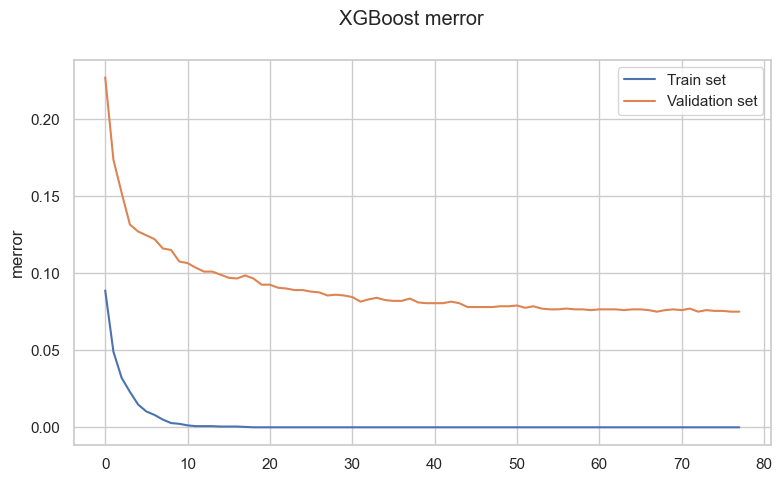


-----------------Confusion matrix---------------------

[[194   0   1   1   1   0   3   0   4   0]
 [  0 200   3   1   0   0   0   1   1   1]
 [  2   2 183   2   3   2   1   2   5   1]
 [  1   2   4 193   0   7   0   5   1   0]
 [  0   1   1   0 185   0   0   1   0   4]
 [  2   0   1   6   0 165   1   1   1   2]
 [  0   2   3   0   0   4 169   0   0   0]
 [  0   1   8   3   0   1   0 192   1   7]
 [  0   3   2   0   3   1   2   2 186   1]
 [  3   3   3   2   9   0   0   6   2 183]]

-----------------Key metrics----------------------

Micro precision 0.9250
Macro precision 0.9255

Micro recall 0.9250
Macro recall 0.9258

Micro F1-score 0.9250
Macro F1-score 0.9255


In [122]:
# Create the figures to plot
fig, axs = plt.subplots(figsize=(9, 5))

axs.plot(xgb_clf.evals_result()['validation_0']['merror'], label='Train set')
axs.plot(xgb_clf.evals_result()['validation_1']['merror'], label='Validation set')
axs.legend()
fig.suptitle('XGBoost merror')
axs.set_ylabel('merror')
plt.show()

# Print key metrics

print('\n-----------------Confusion matrix---------------------\n')
print(confusion_matrix(y_valid, pred))

print('\n-----------------Key metrics----------------------\n')
print('Micro precision {:.4f}'.format(precision_score(y_valid, pred, average='micro')))
print('Macro precision {:.4f}\n'.format(precision_score(y_valid, pred, average='macro'))) 

print('Micro recall {:.4f}'.format(recall_score(y_valid, pred, average='micro')))
print('Macro recall {:.4f}\n'.format(recall_score(y_valid, pred, average='macro')))

print('Micro F1-score {:.4f}'.format(f1_score(y_valid, pred, average='micro')))
print('Macro F1-score {:.4f}'.format(f1_score(y_valid, pred, average='macro')))

#### Hyperparameter search using Hyperopt

In [90]:
from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

In [141]:
# Lets perform the hyperparam search using hyperopt

## Define the objective function
def objective(args):
    clf = xgb.XGBClassifier(n_estimators=int(args['n_estimators']),
                            max_depth=int(args['max_depth']),
                            gamma=args['gamma'],
                            reg_lambda=args['reg_lambda'],
                            learning_rate=args['learning_rate'],
                           num_class=10,
                           early_stopping_rounds=10,
                            objective='multi:softmax',
                            eval_metric='merror')

    clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            verbose=False)

    loss = accuracy_score(y_valid, clf.predict(X_valid))

    return {'loss': -loss, 'model': clf, 'status': STATUS_OK}
                            

In [142]:
# Define the space for search

space = {'max_depth': hp.quniform('max_depth', 1, 23, 1),
         'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
         'gamma': hp.uniform('gamma', 1, 9),
         'reg_lambda': hp.uniform('reg_alpha', 0, 1),
        'learning_rate': hp.loguniform('learning_rate', -5, 0)}

In [143]:
# Define the Trials object
trials = Trials()

# run the search
best = fmin(objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=10)

100%|██████████████████████████████████████████████████████████| 10/10 [22:13<00:00, 133.39s/trial, best loss: -0.9945]


In [146]:
# Getting the best model out of the trials dict

best_model = trials.results[6]['model']


In [147]:
# Getting it score on the test set and compairing it with the basemodel result

opt_pred = best_model.predict(X_test)

print('Accuracy of hyperopt model on unseen data is {}'.format(accuracy_score(y_test, opt_pred)))

Accuracy of hyperopt model on unseen data is 0.9578285714285715


- It looks like basemodel performed better than the one obtained with the hyperopt

In [148]:
# Using the baseline model to predict the test set

predictions = xgb_clf.predict(X_test)

print('Accuracy on unseen data is {}'.format(accuracy_score(y_test, predictions)))


Accuracy on unseen data is 0.9722857142857143


### The best obtained accuracy is `0.9722`. Serializing this model using the pickle module

In [132]:
import pickle

In [133]:
# save the model 

model_file = 'model_pickle.pkl'
pickle.dump(xgb_clf, open(model_file, 'wb'))